<a href="https://colab.research.google.com/github/mahamed-abdulle/FYP-Prototype/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import numpy as np
from PIL import Image
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Set your directory path
covid_directory_path = '/Users/mahamedabdulle/Documents/BSc Computer Science/Year 3/Final Year Project/archive (1)/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images'
non_covid_directory_path = '/Users/mahamedabdulle/Documents/BSc Computer Science/Year 3/Final Year Project/archive (1)/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images'
normal_directory_path = '/Users/mahamedabdulle/Documents/BSc Computer Science/Year 3/Final Year Project/archive (1)/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images'

def create_dataframe_from_directory(data_dir, label):
    filenames = []
    labels = []
    if os.path.isdir(data_dir):
        for filename in os.listdir(data_dir):
            file_path = os.path.join(data_dir, filename)
            if os.path.isfile(file_path):
                filenames.append(file_path)
                labels.append(label)
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })

covid_data = create_dataframe_from_directory(covid_directory_path, "COVID-19")
non_covid_data = create_dataframe_from_directory(non_covid_directory_path,"Non-COVID")
normal_data = create_dataframe_from_directory(normal_directory_path,"Normal")

In [ ]:
print(f"COVID-19 Data length: {len(covid_data)}")
print(f"Non-COVID-19 Data length: {len(non_covid_data)}")
print(f"Normal Data length: {len(normal_data)}")

COVID-19 Data length: 1903
Non-COVID-19 Data length: 1802
Normal Data length: 1712


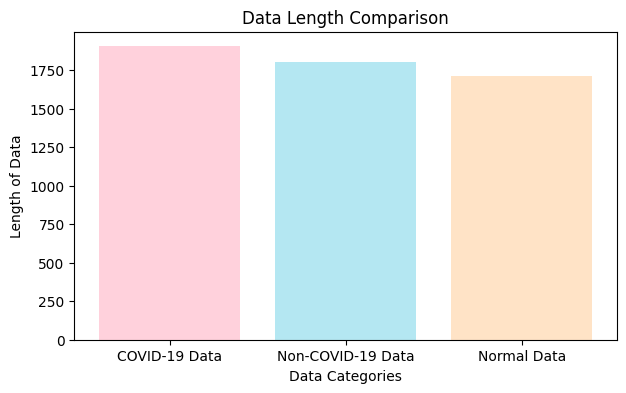

In [ ]:
covid_data_length = len(covid_data)
non_covid_data_length = len(non_covid_data)
normal_data_length = len(normal_data)

# Data to be plotted
categories = ['COVID-19 Data', 'Non-COVID-19 Data', 'Normal Data']
lengths = [covid_data_length, non_covid_data_length, normal_data_length]

# Create bar graph
plt.figure(figsize=(7, 4))
plt.bar(categories, lengths, color=['#ffd1dc', '#b4e7f2', '#ffe3c6'])

# Add title and labels
plt.title('Data Length Comparison')
plt.xlabel('Data Categories')
plt.ylabel('Length of Data')

# Show the graph
plt.show()


In [ ]:
all_data = pd.concat([covid_data, non_covid_data, normal_data])
print(f"All Data length: {len(all_data)}")

All Data length: 5417


In [ ]:
# Data lengths for each class
covid_data_length = len(covid_data)
non_covid_data_length = len(non_covid_data)
normal_data_length = len(normal_data)

# Total data points
total_data_points = covid_data_length + non_covid_data_length + normal_data_length

# Most common class (maximum of the three classes)
most_common_class_count = max(covid_data_length, non_covid_data_length, normal_data_length)

# Calculating baseline accuracy
baseline_accuracy = most_common_class_count / total_data_points
baseline_accuracy_percentage = baseline_accuracy * 100  # converting to percentage
print("Baseline Accuracy: ",baseline_accuracy_percentage)

Baseline Accuracy:  35.13014583717925


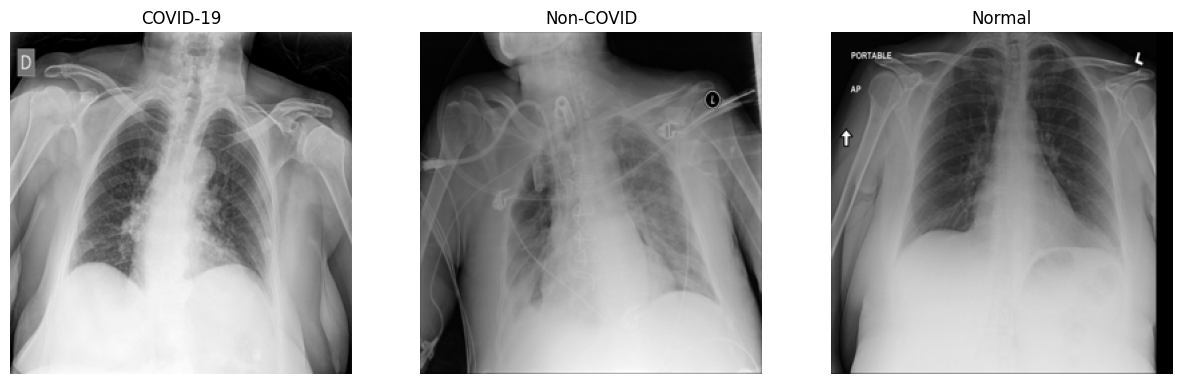

In [ ]:
def display_image(dataframe1,dataframe2,dataframe3):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes[0].imshow(Image.open(dataframe1['filename'][0]),cmap="gray")
    axes[0].set_title('COVID-19')
    axes[0].axis('off')

    axes[1].imshow(Image.open(dataframe2['filename'][0]),cmap="gray")
    axes[1].set_title('Non-COVID')
    axes[1].axis('off')

    axes[2].imshow(Image.open(dataframe3['filename'][0]),cmap="gray")
    axes[2].set_title('Normal')
    axes[2].axis('off')

    plt.show()


display_image(covid_data,non_covid_data,normal_data)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into 70% training and 30% temporary (test + validation)
train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42)

# Splitting the temporary data into 66.7% testing and 33.3% validation
# This results in 20% testing and 10% validation of the original data
test_data, val_data = train_test_split(temp_data, test_size=0.333, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_height = 244
image_width = 244
batch_size = 32
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# For validation and test sets, usually, only rescaling is used
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(image_height, image_width),
    batch_size=batch_size
)

validation_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(image_height, image_width),
    batch_size=batch_size
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False  # Usually, we don't shuffle the test data
)


Found 3791 validated image filenames belonging to 3 classes.
Found 542 validated image filenames belonging to 3 classes.
Found 1084 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),  # First Convolutional Layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),  # Second Convolutional Layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),  # Reducing the number of neurons in the Dense layer
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 for three classes (COVID, Non-COVID, Normal)
])



In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 222784)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# Evaluating the model on the test set before training
initial_test_loss, initial_test_accuracy = model.evaluate(test_generator)
print('Initial Test accuracy:', initial_test_accuracy)

34/34 [==============================] - 3s 81ms/step - loss: 1.1101 - accuracy: 0.2934
Initial Test accuracy: 0.2933579385280609


In [ ]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

# Evaluating the model on the test set after training
final_test_loss, final_test_accuracy = model.evaluate(test_generator)
print('Final Test accuracy:', final_test_accuracy)

Epoch 1/10
118/118 [==============================] - 39s 331ms/step - loss: 1.3919 - accuracy: 0.4648 - val_loss: 0.9762 - val_accuracy: 0.5430
Epoch 2/10
118/118 [==============================] - 39s 331ms/step - loss: 0.9696 - accuracy: 0.5411 - val_loss: 0.8769 - val_accuracy: 0.5664
Epoch 3/10
118/118 [==============================] - 38s 323ms/step - loss: 0.9279 - accuracy: 0.5579 - val_loss: 0.9860 - val_accuracy: 0.5371
Epoch 4/10
118/118 [==============================] - 40s 337ms/step - loss: 0.9140 - accuracy: 0.5903 - val_loss: 0.8402 - val_accuracy: 0.5996
Epoch 5/10
118/118 [==============================] - 40s 340ms/step - loss: 0.8296 - accuracy: 0.6233 - val_loss: 0.8020 - val_accuracy: 0.6270
Epoch 6/10
118/118 [==============================] - 41s 344ms/step - loss: 0.8255 - accuracy: 0.6350 - val_loss: 0.7739 - val_accuracy: 0.6504
Epoch 7/10
118/118 [==============================] - 40s 339ms/step - loss: 0.8492 - accuracy: 0.6310 - val_loss: 0.8720 - val_ac

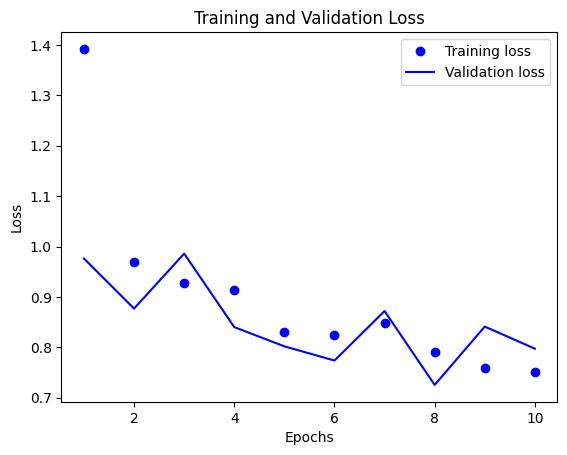

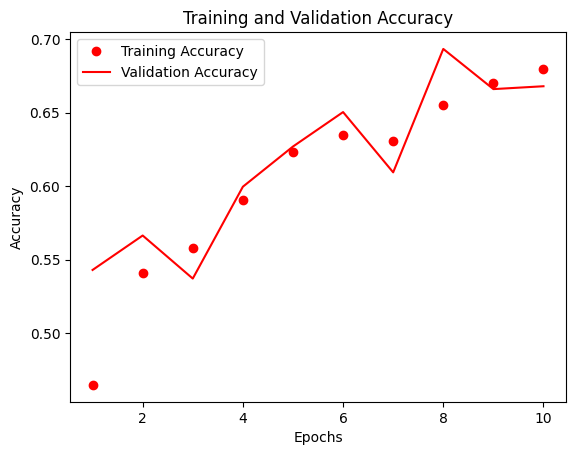

In [ ]:
# Extracting data from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure()
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'accuracy' in history.history:
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    plt.figure()
    plt.plot(epochs, training_accuracy, 'ro', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()


In [ ]:
# 1. Generate Predictions
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size)

# 2. Convert Predictions to Class Labels
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the length of true_classes matches that of predicted_classes
# This is important as the generator could loop indefinitely
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

# 3. Calculate F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"F1-Score: {f1}")


33/33 [==============================] - 3s 85ms/step
F1-Score: 0.6380332326400285


In [ ]:
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall: {recall}")

Recall: 0.6524116252256956


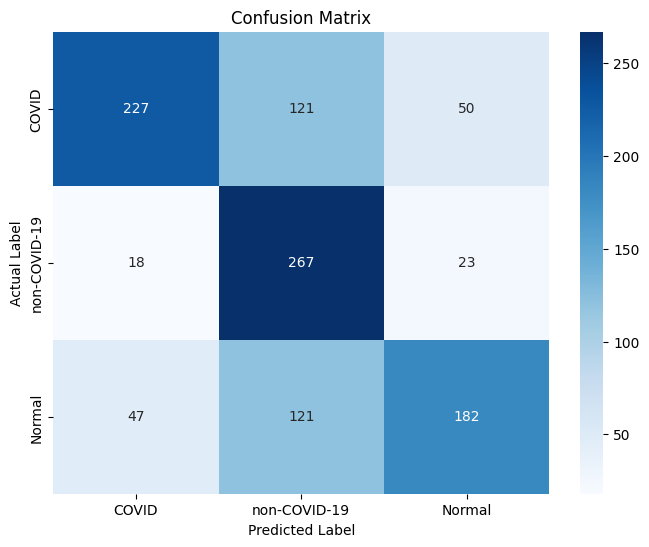

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues',
            xticklabels=['COVID', 'non-COVID-19', 'Normal'],
            yticklabels=['COVID', 'non-COVID-19', 'Normal'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()